In [1]:
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import pandas as pd
import numpy as np
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display
from sqlalchemy.engine import URL
import ast

In [2]:
USER = "slqleo"
PWD  = "G?,6(4(q$GMw"          # sin escaparla, URL.create se encarga
HOST = "45.169.253.115"       # o el host que realmente tenga la DB
PORT = 3306

srv_url = URL.create(
    drivername="mysql+pymysql",
    username=USER,
    password=PWD,
    host=HOST,
    port=PORT,
    query={"charset": "utf8mb4"},
)
engine_srv = create_engine(srv_url, pool_pre_ping=True)

with engine_srv.connect() as conn:
    server = conn.execute(text("SELECT @@hostname, @@port, @@version")).one()
    print("Conectado a:", server)

Conectado a: ('serverbd', 3306, '8.0.44-0ubuntu0.22.04.1')


# Usabilidad

In [3]:
with engine_srv.connect() as conn:
    usability_events = pd.read_sql(
        text("SELECT * FROM slq_main.usability_events"),
        conn
    )

usability_events.head(2)

,id,function_used,slq_company_id,sys_user_id,acl_role_id,created_at,updated_at
0,1,Visualización del detalle de un producto,168,2146.0,1.0,2025-03-26 21:10:48,2025-03-26 21:10:48
1,2,Visualización del detalle de un producto,168,2146.0,1.0,2025-03-26 21:11:08,2025-03-26 21:11:08


In [4]:
query = text("""
SELECT 
    u.function_used,
    u.created_at,
    u.sys_user_id AS usuario,
    e.nombre AS empresa
FROM slq_main.usability_events u
INNER JOIN slq_main.slq_empresas e 
    ON u.slq_company_id = e.id
LEFT JOIN slq_main.sys_users ur 
    ON u.sys_user_id = ur.id
WHERE 
    e.activo = 1
    AND ur.activo = 1
    AND ur.interno = 0
    AND e.nombre NOT REGEXP 'Mejora|academy|prueba'
""")

with engine_srv.connect() as conn:
    df_usuarios = pd.read_sql(query, conn)

df_usuarios

,function_used,created_at,usuario,empresa
0,Acceso al módulo de productos,2025-03-27 08:01:32,26,CAJA DE COMPENSACIÓN FAMILIAR COMPENSAR
1,Visualización del detalle de un producto,2025-03-27 08:02:05,26,CAJA DE COMPENSACIÓN FAMILIAR COMPENSAR
2,Descarga de etiquetas,2025-03-27 08:02:32,26,CAJA DE COMPENSACIÓN FAMILIAR COMPENSAR
3,Acceso al módulo de productos,2025-03-27 08:16:25,26,CAJA DE COMPENSACIÓN FAMILIAR COMPENSAR
4,Visualización del detalle de un producto,2025-03-27 08:17:02,26,CAJA DE COMPENSACIÓN FAMILIAR COMPENSAR
...,...,...,...,...
152079,Ingreso a login,2025-12-02 08:14:10,3173,LEWIS ENERGY COLOMBIA INC
152080,Ingreso a login,2025-12-02 08:15:16,3173,LEWIS ENERGY COLOMBIA INC
152081,Visualización del detalle de un producto,2025-12-02 08:17:06,3173,LEWIS ENERGY COLOMBIA INC
152082,Descarga de FDS,2025-12-02 08:17:32,3173,LEWIS ENERGY COLOMBIA INC


In [5]:
df = df_usuarios.copy()

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_usuarios.copy()

df['created_at'] = pd.to_datetime(df['created_at'])
df = df.sort_values(['empresa', 'created_at'])

# Diferencia en minutos entre eventos de la misma empresa
df['diff_min'] = df.groupby('empresa')['created_at'].diff().dt.total_seconds().div(60)

# Nueva sesión si:
# - es el primer evento de la empresa, o
# - pasaron más de 30 min desde el evento anterior
df['nueva_sesion'] = df['diff_min'].isna() | (df['diff_min'] > 30)

# session_id único global
df['session_id'] = df.groupby('empresa')['nueva_sesion'].cumsum()

# Fecha
df['fecha'] = df['created_at'].dt.date


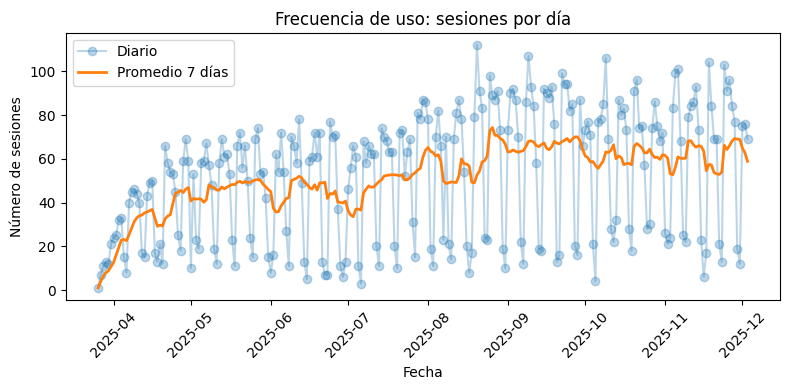

In [7]:
sesiones_por_dia = df.groupby('fecha')['session_id'].nunique()
freq_7d = sesiones_por_dia.rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(8,4))
plt.plot(sesiones_por_dia.index, sesiones_por_dia.values, alpha=0.3, marker='o', linestyle='-')
plt.plot(freq_7d.index, freq_7d.values, linewidth=2)
plt.title('Frecuencia de uso: sesiones por día')
plt.xlabel('Fecha')
plt.ylabel('Número de sesiones')
plt.xticks(rotation=45)
plt.legend(['Diario', 'Promedio 7 días'])
plt.tight_layout()
plt.show()


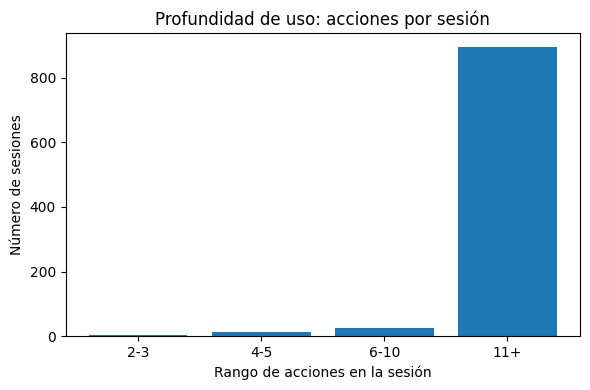

In [8]:
acciones_por_sesion = df.groupby('session_id')['function_used'].count()

def bucket(n):
    if n == 1:        return '1'
    elif n <= 3:      return '2-3'
    elif n <= 5:      return '4-5'
    elif n <= 10:     return '6-10'
    else:             return '11+'

prof_buckets = acciones_por_sesion.map(bucket)
prof_counts = prof_buckets.value_counts().reindex(['1','2-3','4-5','6-10','11+'])

plt.figure(figsize=(6,4))
plt.bar(prof_counts.index, prof_counts.values)
plt.title('Profundidad de uso: acciones por sesión')
plt.xlabel('Rango de acciones en la sesión')
plt.ylabel('Número de sesiones')
plt.tight_layout()
plt.show()


Tasa de conversión ver → FDS: 0.9493534482758621
Tasa de conversión ver → Etiquetas: 0.915948275862069


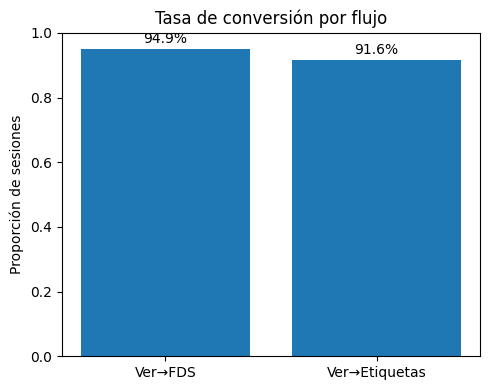

In [9]:
df['es_ver'] = df['function_used'].eq('Visualización del detalle de un producto')
df['es_fds'] = df['function_used'].eq('Descarga de FDS')
df['es_etq'] = df['function_used'].eq('Descarga de etiquetas')

sesiones = df.groupby('session_id').agg(
    vio_producto = ('es_ver', 'max'),
    descargo_fds = ('es_fds', 'max'),
    descargo_etq = ('es_etq', 'max'),
)

sesiones_con_ver = sesiones[sesiones['vio_producto']]

conv_fds = sesiones_con_ver['descargo_fds'].mean()
conv_etq = sesiones_con_ver['descargo_etq'].mean()

print('Tasa de conversión ver → FDS:', conv_fds)
print('Tasa de conversión ver → Etiquetas:', conv_etq)

plt.figure(figsize=(5,4))
plt.bar(['Ver→FDS', 'Ver→Etiquetas'], [conv_fds, conv_etq])
plt.title('Tasa de conversión por flujo')
plt.ylabel('Proporción de sesiones')
plt.ylim(0, 1)
for i,v in enumerate([conv_fds, conv_etq]):
    plt.text(i, v+0.02, f'{v:.1%}', ha='center')
plt.tight_layout()
plt.show()


FDS (min) limpio:
 count    247.000000
mean       8.236572
std       12.703246
min        0.133333
25%        0.383333
50%        1.533333
75%       10.300000
max       57.650000
dtype: float64
Etiquetas (min) limpio:
 count    604.000000
mean       4.649007
std        9.838313
min        0.166667
25%        0.445833
50%        0.800000
75%        2.516667
max       59.083333
dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_13148\2430340290.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


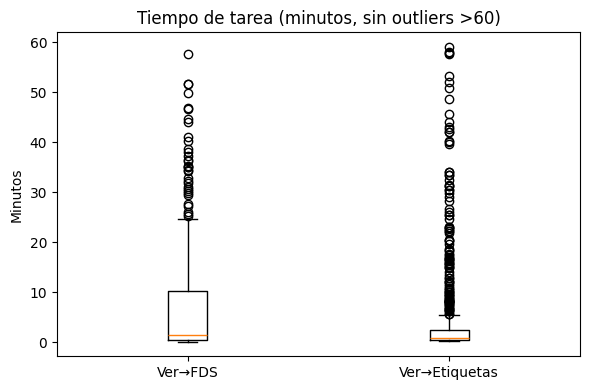

In [10]:
tiempos_fds_min = []
tiempos_etq_min = []

for sesion_id, d in df.groupby('session_id'):
    d = d.sort_values('created_at')
    t_ver = d.loc[d['es_ver'], 'created_at']
    if t_ver.empty:
        continue
    t_ver = t_ver.iloc[0]

    # FDS
    t_fds = d.loc[d['es_fds'], 'created_at']
    if not t_fds.empty:
        t_fds = t_fds.iloc[0]
        if t_fds > t_ver:
            diff_min = (t_fds - t_ver).total_seconds() / 60
            tiempos_fds_min.append(diff_min)

    # Etiquetas
    t_etq = d.loc[d['es_etq'], 'created_at']
    if not t_etq.empty:
        t_etq = t_etq.iloc[0]
        if t_etq > t_ver:
            diff_min = (t_etq - t_ver).total_seconds() / 60
            tiempos_etq_min.append(diff_min)

s_fds = pd.Series(tiempos_fds_min)
s_etq = pd.Series(tiempos_etq_min)

# Quitamos valores locos (por ej. > 60 min)
s_fds_clean = s_fds[s_fds <= 60]
s_etq_clean = s_etq[s_etq <= 60]

print('FDS (min) limpio:\n', s_fds_clean.describe())
print('Etiquetas (min) limpio:\n', s_etq_clean.describe())

plt.figure(figsize=(6,4))
plt.boxplot(
    [s_fds_clean, s_etq_clean],
    labels=['Ver→FDS', 'Ver→Etiquetas']
)
plt.title('Tiempo de tarea (minutos, sin outliers >60)')
plt.ylabel('Minutos')
plt.tight_layout()
plt.show()


                                function_used  \
8               Acceso al módulo de productos   
51                      Descarga de etiquetas   
112            Ingreso al módulo de etiquetas   
167  Visualización del detalle de un producto   
172  Visualización del detalle de un producto   
47                      Descarga de etiquetas   
61                      Descarga de etiquetas   
163  Visualización del detalle de un producto   
165  Visualización del detalle de un producto   
177  Visualización del detalle de un producto   

                             accion_siguiente  conteo  
8    Visualización del detalle de un producto   15363  
51                      Descarga de etiquetas   11437  
112                     Descarga de etiquetas   10874  
167                     Descarga de etiquetas    9758  
172            Ingreso al módulo de etiquetas    9678  
47              Acceso al módulo de productos    8222  
61   Visualización del detalle de un producto    8218  
163         

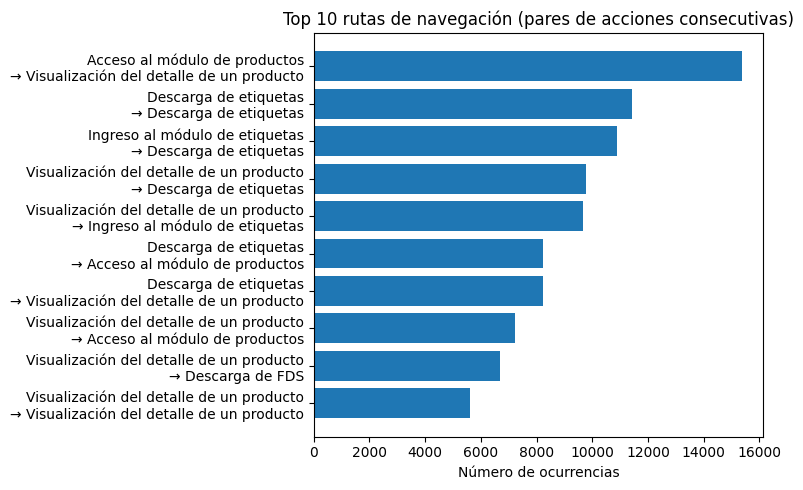

In [11]:
df = df.sort_values(['session_id', 'created_at'])
df['accion_siguiente'] = df.groupby('session_id')['function_used'].shift(-1)

rutas = (
    df
    .dropna(subset=['accion_siguiente'])
    .groupby(['function_used','accion_siguiente'])
    .size()
    .reset_index(name='conteo')
    .sort_values('conteo', ascending=False)
    .head(10)
)

print(rutas)

plt.figure(figsize=(8,5))
plt.barh(
    y = [f"{a}\n→ {b}" for a,b in zip(rutas['function_used'], rutas['accion_siguiente'])],
    width = rutas['conteo']
)
plt.title('Top 10 rutas de navegación (pares de acciones consecutivas)')
plt.xlabel('Número de ocurrencias')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [12]:
# df_usuarios original + lo que ya hicimos:
# columnas mínimas: function_used, created_at, empresa
df = df_usuarios.copy()
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.sort_values(['empresa', 'created_at'])

df['diff_min'] = df.groupby('empresa')['created_at'].diff().dt.total_seconds().div(60)
df['nueva_sesion'] = df['diff_min'].isna() | (df['diff_min'] > 30)
df['session_id'] = df.groupby('empresa')['nueva_sesion'].cumsum()

df['es_ver'] = df['function_used'].eq('Visualización del detalle de un producto')
df['es_fds'] = df['function_used'].eq('Descarga de FDS')
df['es_etq'] = df['function_used'].eq('Descarga de etiquetas')


In [13]:
# Nivel empresa–sesión (CORREGIDO)
sesiones_emp = df.groupby(['empresa', 'session_id']).agg(
    eventos        = ('function_used', 'count'),
    vio_producto   = ('es_ver', 'max'),
    descargo_fds   = ('es_fds', 'max'),   # <-- aquí usamos es_fds
    descargo_etq   = ('es_etq', 'max'),   # <-- aquí usamos es_etq
)

# Resumen por empresa
empresas = sesiones_emp.groupby('empresa').agg(
    sesiones              = ('eventos', 'size'),
    eventos_totales       = ('eventos', 'sum'),
    acciones_prom_sesion  = ('eventos', 'mean'),
    conv_fds              = ('descargo_fds', 'mean'),
    conv_etq              = ('descargo_etq', 'mean'),
).fillna(0)

print(empresas.head())


                                             sesiones  eventos_totales  \
empresa                                                                  
ACOMEQ INGENIERIA S.A.S                             2               10   
ADAMA                                              12               85   
AGROSAVIA                                           6               20   
AGUAS DE CARTAGENA S.A                            133             1534   
ALMACENES GENERALES DE DEPOSITO ALMAVIVA SA        20               62   

                                             acciones_prom_sesion  conv_fds  \
empresa                                                                       
ACOMEQ INGENIERIA S.A.S                                  5.000000  0.000000   
ADAMA                                                    7.083333  0.000000   
AGROSAVIA                                                3.333333  0.000000   
AGUAS DE CARTAGENA S.A                                  11.533835  0.157895   
ALMACEN

In [14]:
# Top por sesiones
top_sesiones = empresas.sort_values('sesiones', ascending=False).head(10)

# Top por profundidad
top_profundidad = empresas.sort_values('acciones_prom_sesion', ascending=False).head(10)


In [15]:
emp = empresas.copy()

for col in ['sesiones', 'acciones_prom_sesion']:
    emp[col + '_norm'] = (emp[col] - emp[col].min()) / (emp[col].max() - emp[col].min())

emp['conv_prom'] = (emp['conv_fds'] + emp['conv_etq']) / 2
emp['conv_prom_norm'] = (emp['conv_prom'] - emp['conv_prom'].min()) / (emp['conv_prom'].max() - emp['conv_prom'].min())

emp['indice_usabilidad'] = (
    0.4 * emp['sesiones_norm'] +
    0.3 * emp['acciones_prom_sesion_norm'] +
    0.3 * emp['conv_prom_norm']
)

top_indice = emp.sort_values('indice_usabilidad', ascending=False).head(10)
print(top_indice[['sesiones','acciones_prom_sesion','conv_prom','indice_usabilidad']])


                                         sesiones  acciones_prom_sesion  \
empresa                                                                   
CORONA                                        939             22.523962   
GRAN TIERRA ENERGY COLOMBIA LTD               931              9.823845   
HP COLOMBIA SAS                                 2             40.000000   
CAJA DE COMPENSACIÓN FAMILIAR COMPENSAR       752             10.261968   
GUACAMAYA ENERGY SERVICES S.A.S.              654              9.810398   
BAKER HUGHES                                  643              8.458787   
ETERNA                                         16             31.125000   
YANBAL DE COLOMBIA S A S                      531              9.977401   
NEWREST SERVICES COLOMBIA S.A                 437              9.757437   
CONSTRUCTORA CAPITAL                          446              9.071749   

                                         conv_prom  indice_usabilidad  
empresa                    

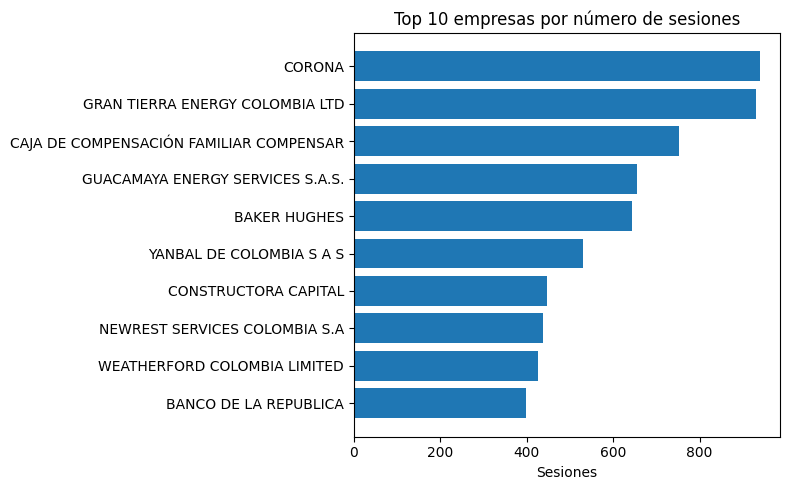

In [16]:
top_sesiones = empresas.sort_values('sesiones', ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.barh(top_sesiones.index, top_sesiones['sesiones'])
plt.title('Top 10 empresas por número de sesiones')
plt.xlabel('Sesiones')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


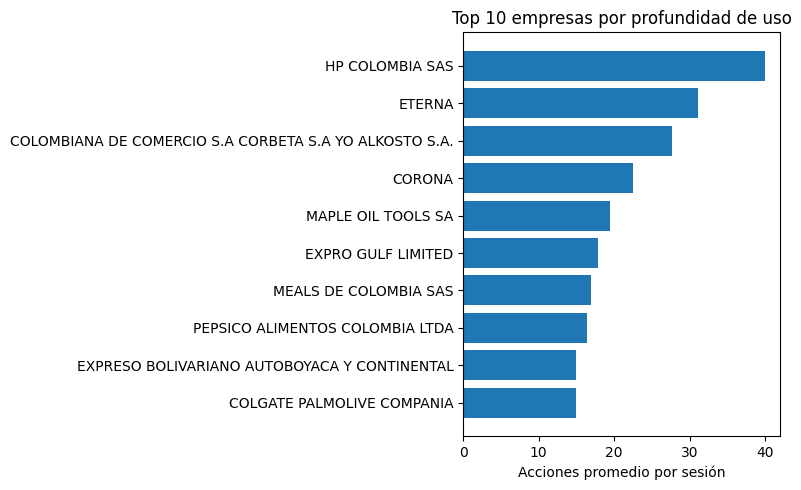

In [17]:
top_profundidad = empresas.sort_values('acciones_prom_sesion', ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.barh(top_profundidad.index, top_profundidad['acciones_prom_sesion'])
plt.title('Top 10 empresas por profundidad de uso')
plt.xlabel('Acciones promedio por sesión')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


                                         sesiones  acciones_prom_sesion  \
empresa                                                                   
CORONA                                        939             22.523962   
GRAN TIERRA ENERGY COLOMBIA LTD               931              9.823845   
HP COLOMBIA SAS                                 2             40.000000   
CAJA DE COMPENSACIÓN FAMILIAR COMPENSAR       752             10.261968   
GUACAMAYA ENERGY SERVICES S.A.S.              654              9.810398   
BAKER HUGHES                                  643              8.458787   
ETERNA                                         16             31.125000   
YANBAL DE COLOMBIA S A S                      531              9.977401   
NEWREST SERVICES COLOMBIA S.A                 437              9.757437   
CONSTRUCTORA CAPITAL                          446              9.071749   

                                         conv_prom  indice_usabilidad  
empresa                    

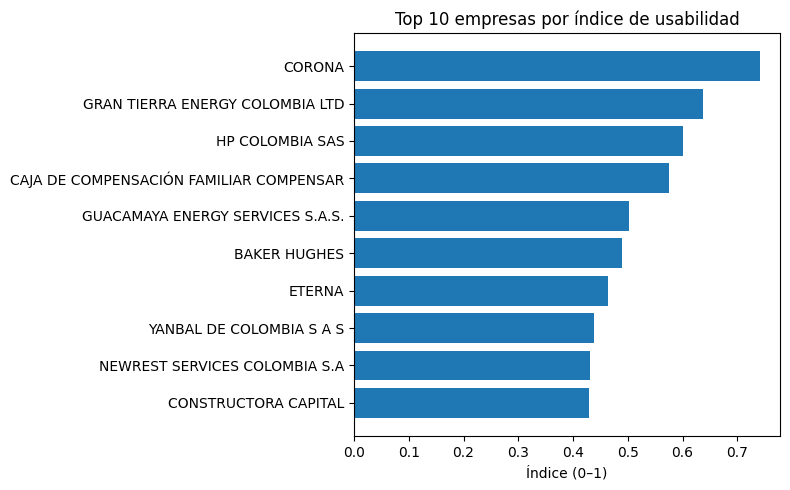

In [18]:
emp = empresas.copy()

# Normalización min–max
for col in ['sesiones', 'acciones_prom_sesion']:
    emp[col + '_norm'] = (emp[col] - emp[col].min()) / (emp[col].max() - emp[col].min())

emp['conv_prom'] = (emp['conv_fds'] + emp['conv_etq']) / 2
emp['conv_prom_norm'] = (emp['conv_prom'] - emp['conv_prom'].min()) / (emp['conv_prom'].max() - emp['conv_prom'].min())

# Peso a cada componente (ajústalo si quieres)
emp['indice_usabilidad'] = (
    0.4 * emp['sesiones_norm'] +
    0.3 * emp['acciones_prom_sesion_norm'] +
    0.3 * emp['conv_prom_norm']
)

top_indice = emp.sort_values('indice_usabilidad', ascending=False).head(10)

print(top_indice[['sesiones','acciones_prom_sesion','conv_prom','indice_usabilidad']])

plt.figure(figsize=(8,5))
plt.barh(top_indice.index, top_indice['indice_usabilidad'])
plt.title('Top 10 empresas por índice de usabilidad')
plt.xlabel('Índice (0–1)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [19]:
df_usuarios.to_csv("empresas.csv")

# Productos

In [9]:
query = text("""
SELECT 
    p.id,
    p.created_at,
    p.updated_at,
    u_crea.name  AS usuario_crea,
    u_upd.name   AS usuario_actualiza
FROM slq_main.prod_productos p

-- ÚLTIMO AUDIT DE CREACIÓN POR PRODUCTO
LEFT JOIN (
    SELECT 
        a.auditable_id,
        COALESCE(a.usu_id, a.user_id) AS user_id
    FROM slq_main.audits a
    WHERE 
        a.auditable_type = 'App\\\\Http\\\\ApiCore\\\\Productos\\\\ProdProducto'
        AND a.event = 'created'
        AND a.changed_at = (
            SELECT MAX(a2.changed_at)
            FROM slq_main.audits a2
            WHERE 
                a2.auditable_type = 'App\\\\Http\\\\ApiCore\\\\Productos\\\\ProdProducto'
                AND a2.event = 'created'
                AND a2.auditable_id = a.auditable_id
        )
) ac ON ac.auditable_id = p.id

LEFT JOIN slq_main.sys_users u_crea
    ON u_crea.id = ac.user_id

-- ÚLTIMO AUDIT DE UPDATE POR PRODUCTO
LEFT JOIN (
    SELECT 
        a.auditable_id,
        COALESCE(a.usu_id, a.user_id) AS user_id
    FROM slq_main.audits a
    WHERE 
        a.auditable_type = 'App\\\\Http\\\\ApiCore\\\\Productos\\\\ProdProducto'
        AND a.event = 'updated'
        AND a.changed_at = (
            SELECT MAX(a2.changed_at)
            FROM slq_main.audits a2
            WHERE 
                a2.auditable_type = 'App\\\\Http\\\\ApiCore\\\\Productos\\\\ProdProducto'
                AND a2.event = 'updated'
                AND a2.auditable_id = a.auditable_id
        )
) au ON au.auditable_id = p.id

LEFT JOIN slq_main.sys_users u_upd
    ON u_upd.id = au.user_id

WHERE 
    p.modulo_creacion = 'productos'
    AND p.bloqueo IN (1, 2)
    AND p.activo = 1
""")

with engine_srv.connect() as conn:
    productos = pd.read_sql(query, conn)

productos


,id,created_at,updated_at,usuario_crea,usuario_actualiza
0,6,2019-02-12 12:36:29,2025-09-15 16:35:08,None,Katherine Forero
1,8,2019-02-12 12:36:30,2025-02-25 22:01:23,None,Katherine Forero
2,9,2019-02-12 12:36:30,2025-09-15 16:35:09,None,Alejandro Puccini
3,14,2019-02-12 12:36:30,2025-09-16 10:54:40,None,Danny Garizabalo
4,14,2019-02-12 12:36:30,2025-09-16 10:54:40,None,Danny Garizabalo
...,...,...,...,...,...
34835,69263,2025-12-01 10:55:24,2025-12-01 13:21:02,Claudia Marcela Cortes Prieto,Claudia Marcela Cortes Prieto
34836,69264,2025-12-01 10:55:31,2025-12-01 13:21:02,Claudia Marcela Cortes Prieto,Claudia Marcela Cortes Prieto
34837,69267,2025-12-01 11:58:07,2025-12-01 12:06:45,Angel Orozco,None
34838,69268,2025-12-01 12:00:56,2025-12-01 12:05:57,Angel Orozco,None


In [56]:
query = text("""
WITH audit_crea AS (
    SELECT 
        a.auditable_id,
        COALESCE(a.usu_id, a.user_id) AS user_id,
        ROW_NUMBER() OVER (
            PARTITION BY a.auditable_id
            ORDER BY a.changed_at ASC, a.id ASC
        ) AS rn
    FROM slq_main.audits a
    WHERE 
        a.auditable_type = 'App\\\\Http\\\\ApiCore\\\\Productos\\\\ProdProducto'
        AND a.event = 'created'
),

audit_upd AS (
    SELECT 
        a.auditable_id,
        COALESCE(a.usu_id, a.user_id) AS user_id,
        a.changed_at,
        ROW_NUMBER() OVER (
            PARTITION BY a.auditable_id
            ORDER BY a.changed_at DESC, a.id DESC
        ) AS rn
    FROM slq_main.audits a
    WHERE 
        a.auditable_type = 'App\\\\Http\\\\ApiCore\\\\Productos\\\\ProdProducto'
        AND a.event = 'updated'
)

SELECT 
    p.id,
    p.created_at,

    -- updated_at: fecha del último updated en audit; si no hay, fallback a p.updated_at
    COALESCE(au.changed_at, p.updated_at) AS updated_at,

    -- usuario_crea: si hay audit de creación, ese; si no, usuario_registro
    COALESCE(u_crea.name, u_reg.name) AS usuario_crea,

    -- usuario_actualiza: último updated sobre ProdProducto
    u_upd.name AS usuario_actualiza

FROM slq_main.prod_productos p

-- CREADOR
LEFT JOIN audit_crea ac
    ON ac.auditable_id = p.id
    AND ac.rn = 1
LEFT JOIN slq_main.sys_users u_crea
    ON u_crea.id = ac.user_id

-- FALLBACK: usuario_registro
LEFT JOIN slq_main.sys_users u_reg
    ON u_reg.id = p.usuario_registro

-- ÚLTIMO UPDATE DESDE AUDIT
LEFT JOIN audit_upd au
    ON au.auditable_id = p.id
    AND au.rn = 1
LEFT JOIN slq_main.sys_users u_upd
    ON u_upd.id = au.user_id

WHERE 
    p.modulo_creacion = 'productos'
    AND p.bloqueo IN (1, 2)
    AND p.activo = 1
""")

with engine_srv.connect() as conn:
    productos = pd.read_sql(query, conn)

productos


,id,created_at,updated_at,usuario_crea,usuario_actualiza
0,6,2019-02-12 12:36:29,2025-03-23 11:49:57,None,Katherine Forero
1,8,2019-02-12 12:36:30,2024-10-28 13:40:15,None,Katherine Forero
2,9,2019-02-12 12:36:30,2023-06-26 09:13:36,None,Alejandro Puccini
3,14,2019-02-12 12:36:30,2023-03-23 17:40:42,None,Liliana Lopez
4,15,2019-02-12 12:36:30,2024-12-22 14:59:46,None,Leonardo Guzman
...,...,...,...,...,...
29279,69264,2025-12-01 10:55:31,2025-12-01 11:04:42,Claudia Marcela Cortes Prieto,Claudia Marcela Cortes Prieto
29280,69267,2025-12-01 11:58:07,2025-12-01 12:06:45,Angel Orozco,None
29281,69268,2025-12-01 12:00:56,2025-12-01 12:05:57,Angel Orozco,None
29282,69269,2025-12-01 12:02:44,2025-12-01 12:05:12,Angel Orozco,None


In [57]:
productos.to_csv("productos.csv")